In [1]:
import warnings
warnings.filterwarnings('ignore')

import os.path as osp
import os
from IPython.display import Image
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as path
%matplotlib inline

from colorsys import rgb_to_hsv

from skimage.io import imread, imsave
from skimage.segmentation import slic
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.morphology import closing, binary_closing, binary_opening, square
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import gaussian, sobel
from skimage import img_as_uint
from skimage.exposure import histogram
from skimage.feature import canny



color = {
    'black':[0,0,0],
    'white':[255,255,255],
    'red':[255,0,0],
    'green':[0,255,0],
    'blue':[0,0,255],
    'magenta':[255,255,0]
}

def show_image(image, cmap=None, title=None):
    fig = plt.figure(figsize=(8,8))
    plt.axis('off')
    if image.ndim == 2:
        cmap='gray'
    plt.imshow(image, aspect='auto', cmap=cmap)
    if title:
        fig.suptitle(title)
    plt.show() 
    
def show_hist(image):
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    plt.figure()
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    features = []

    # loop over the image channels
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)

        # plot the histogram
        plt.plot(hist, color = color)
        plt.xlim([0, 256])

# Read and display image

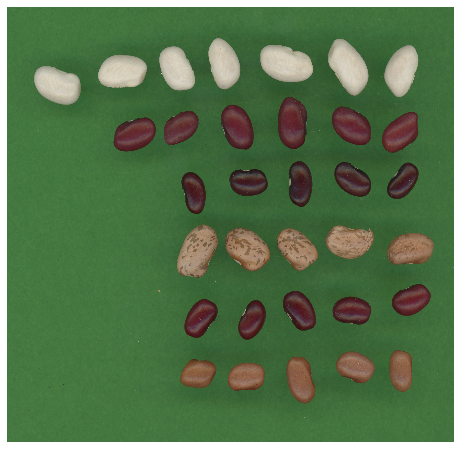

In [2]:
image = imread("MADP_SB_8_003.tif")
show_image(image)

# Use KMeans clustering to group pixels by value
1. Fit the model
2. Aquire the training labels and visualize the results
4. Convert the image to black and white

## 1. Fit the model
From other runs, 4 means gave the best seperation at the lowest cost

In [3]:
K = 4
model = KMeans(n_clusters=K)

# shrink the image for faster training by 1/4 for each axis
features = resize(
    image, 
    (int(image.shape[0] / 4), int(image.shape[1] / 4), image.shape[2]), # shrinks each axis by 1/4
    preserve_range=True # prevents rescaling image from 0 to 1
).astype(int)

# reshape the image into a 2D matrix
features = features.reshape((features.shape[0] * features.shape[1], features.shape[2]))

# train the model
# model.fit(features)

### In the interest of saving time, I'm setting the cluster centers to pretrained results

In [4]:
model.cluster_centers_ = np.array([[ 62.24681959, 108.64087395,  58.5843175 ],
       [196.05566408, 190.00799357, 171.15221035],
       [ 82.88725581,  47.97278208,  45.67010508],
       [145.66400941, 116.08091739,  91.09988348]])

In [5]:
np.argmin(np.sum(abs(model.cluster_centers_ - np.array([50,105, 61])),axis=1))

0

## 2. Aquire the training labels and visualize
KMeans is unsupervised, so the classifications will depend on the starting values for the mean which are selected randomly

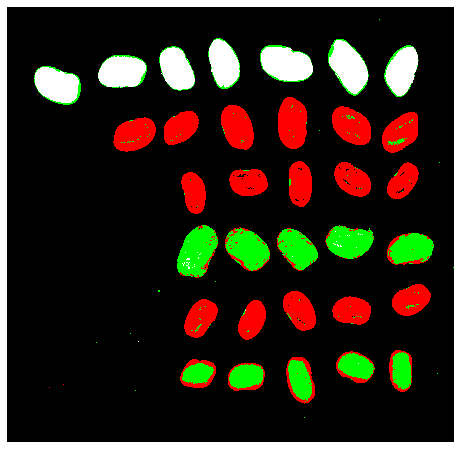

In [6]:
labels = model.predict(image.reshape((image.shape[0] * image.shape[1], image.shape[2])))

# reshape the labels into the proper dimension
labels = labels.reshape(image.shape[:2])

image2 = image.copy()

for i,c in enumerate(list(color.values())[:K]):
    image2[labels == i] = c
    
show_image(image2)

## 3. Convert image to black and white
Set background pixels to 0 and bean pixels to 1

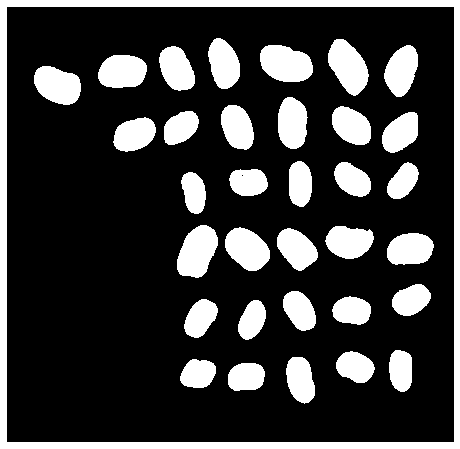

In [7]:
# with backgroun pixels being black, all other pixels can be converted to white
image2[labels == 0] = color['black']
image2[labels != 0] = color['white']

gray = rgb2gray(image2)

# clear speckled black pixels in the image
filter = binary_closing(gray, selem=square(10))
# clear speckled white pixels in the image
filter = binary_opening(filter, selem=square(15))

show_image(filter, cmap='gray')

# Segmentation by removing green pixels
This is necessary because arbitrarily setting the number of Mean Clusters for KMeans doesn't work for images with a varied number of color groups (images with all white beans versus a variety of different colors).

### Method:
1. Find the mean of each channel for every pixel in the image.
2. Find the standard deviation of each channel for every pixel in the image and get the sum.
3. Find every pixel who's difference from the mean is within x standard deviations (x = 2.5 gave a good result).
4. classify based on this condition the background pixels, the apply the binary closing and opening functions to remove noise.

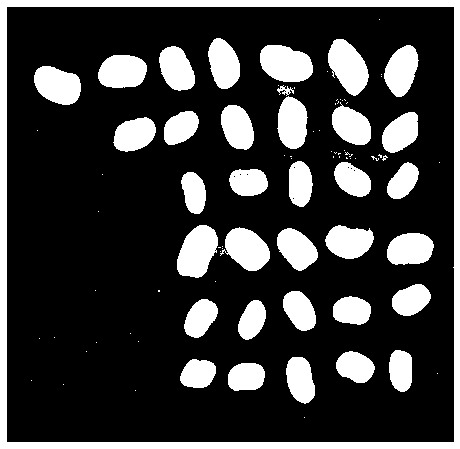

In [8]:
# mean for each channel of the background pixels
bg = np.mean(image[~filter], axis=0)
# sum of the standard deviations for each channel
std = np.sum(np.std(image[~filter], axis=0)) 
# where the difference between the pixel and mean background rgb values is 
# within the factor * std, set of background pixel
bg_px_map = np.sum(abs(np.subtract(image, bg)), axis=2) <= 2.5 * std

filter2 = np.zeros(image.shape[:2])
filter2[~bg_px_map] = 1
show_image(filter2, cmap='gray')

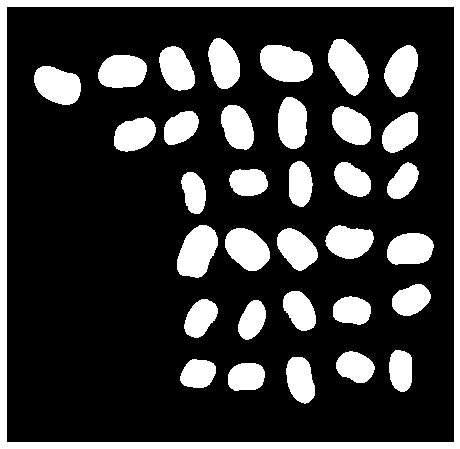

In [9]:
filter2 = binary_opening(filter2, selem=square(20))
filter2 = binary_closing(filter2, selem=square(30))

show_image(filter2, cmap='gray')

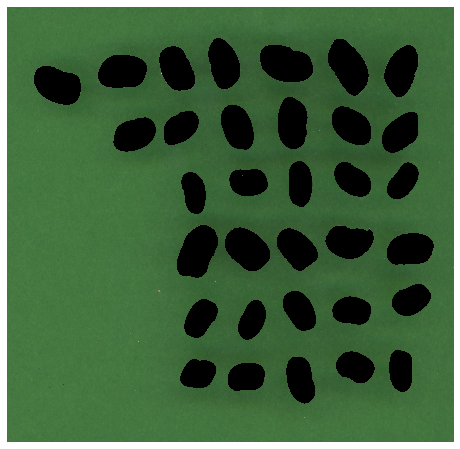

In [10]:
bg_img = image.copy()
bg_img[filter] = [0,0,0]
show_image(bg_img)

# Using STDEV for each channel where all channel absolute differences must be within stdev

[6.10542561 9.58356409 5.38906096]


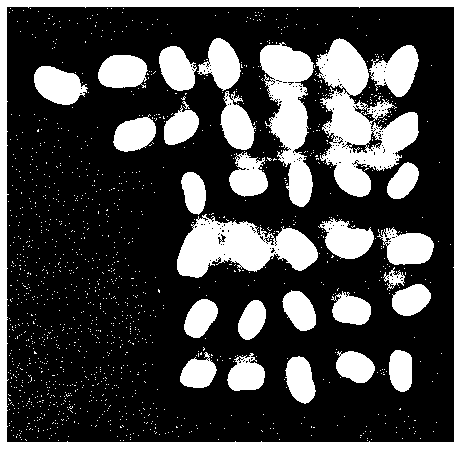

In [11]:
bg_pxs = image[~filter]
# print(np.std(np.sum(bg_pxs, axis = 1)))
std = np.std(bg_pxs, axis=0)
mean = np.mean(bg_pxs, axis=0)
# print(bg_pxs)
# print(mean)
print(std)
# print(bg_pxs - mean)
devs = abs(image.reshape((image.shape[0]*image.shape[1], image.shape[2])) - mean)
bg_map = np.all(devs <= 2.0*std, axis=1).reshape((image.shape[:2]))
bin_image = np.zeros(image.shape[:2])
bin_image[~bg_map] = 1
show_image(bin_image, cmap='gray')

# Whole image histogram

In [12]:
# show_hist(image)

# Background image histogram

In [13]:
# show_hist(bg_img)

# The filter is now ready to be used to obtain only the bean pixels

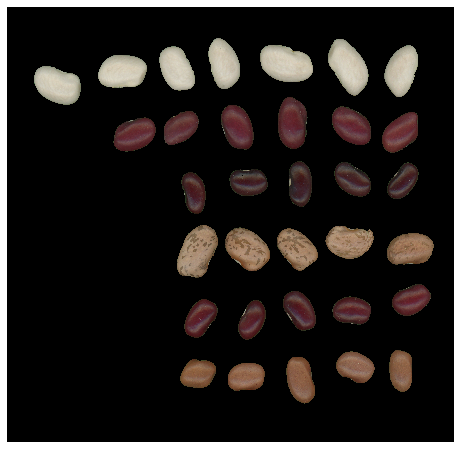

In [14]:
segmented_image = image.copy()
segmented_image[filter == 0] = color['black']
show_image(segmented_image)

# Next step is to isolate rows of beans
1. Obtain bounding Boxes
2. Group rows by finding the interval that intersects the largest number of bounding boxes for each bean

## 1. Obtain bounding Boxes

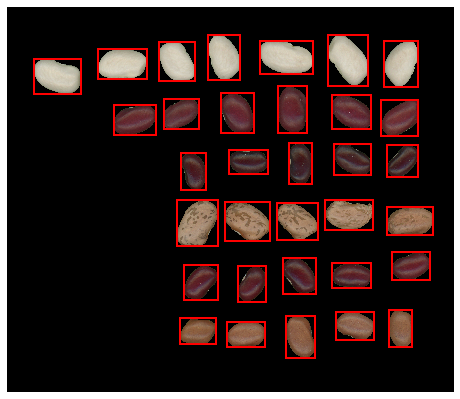

In [15]:
label_image = label(filter)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(segmented_image)

regions = []

for region in regionprops(label_image):
    regions.append(region)
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.show()

In [16]:
reg = regions[0]
x0,y0,x1,y1 = reg.bbox
np.mean(segmented_image[x0:x1, y0:y1][reg.image], axis=0)

array([188.682868  , 183.19785827, 164.37049337])

# 2. Isolate rows of beans
This was a tricky algorithm to implement.
It iterates through the bounding boxes top to bottom and keeps track of the inner interval until it finds bean with a bounding box that does not overlap with any of the current tracked bounding boxes. Then it stores the active bounding box set and resets the interval and active bounding box set to []

In [17]:
# the bounding boxes come sorted top to bottom by default
regions = sorted(regions, key=lambda x: x.bbox[0])

BEG = 0
END = 2

# initialize variables
rows = [] # will store the bounding box rows by interval
upper, lower = regions[0].bbox[BEG], regions[0].bbox[END] # the internal interval of the activate set
active = [] # activae set of bounding boxes

for region in regions:
    if region.bbox[BEG] > lower:
        # store previous params 
        rows.append(sorted(active, key=lambda x: x.bbox[1]))
        active = [] # will add current bbox to active set later later
        upper = region.bbox[BEG] # set upper interval bound
        lower = region.bbox[END] # set lower interval bound
    else:
        if region.bbox[BEG] > upper:
            upper = region.bbox[BEG]
        if region.bbox[END] < lower:
            lower = region.bbox[END]

    active.append(region)

#     plot_bboxes(segmented_image, active, upper=upper, lower=lower)
  
rows.append(sorted(active, key=lambda x: x.bbox[1]))

In [19]:
# with open('alg.gif','rb') as f:
#     display(Image(data=f.read(), format='png'))

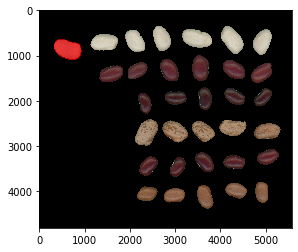

In [37]:
### Test Code
fig, ax = plt.subplots()
plt.imshow(rows[0][0].filled_image)

coords = np.where(rows[0][0].filled_image)
coords = list(zip([x + rows[0][0].bbox[1] for x in coords[1]], [y + rows[0][0].bbox[0] for y in coords[0]]))
ax.imshow(segmented_image)
patch = mpatches.Polygon(coords, edgecolor='r', alpha=0.7)
ax.add_patch(patch)
plt.show()

In [ ]:
wbbox = rows[0][0].bbox
rbbox = rows[1][0].bbox
gsbbox = rows[3][0].bbox

white_bean = segmented_image[wbbox[0]:wbbox[2], wbbox[1]:wbbox[3]]
red_bean   = segmented_image[rbbox[0]:rbbox[2], rbbox[1]:rbbox[3]]
gray_speckled_bean = segmented_image[gsbbox[0]:gsbbox[2], gsbbox[1]:gsbbox[3]]

fig, ax = plt.subplots(ncols=3, figsize=(10,5))
ax[0].imshow(white_bean)
ax[1].imshow(red_bean)
ax[2].imshow(gray_speckled_bean)
for x in ax: x.set_axis_off()
plt.show()


In [ ]:
white_hsv = rgb2hsv(white_bean)
red_hsv = rgb2hsv(red_bean)
gray_spek_hsv = rgb2hsv(gray_speckled_bean)

white_hsv_ar = white_hsv.reshape((white_hsv.shape[0] * white_hsv.shape[1], 3))
red_hsv_ar = red_hsv.reshape((red_hsv.shape[0] * red_hsv.shape[1], 3))
gray_spek_hsv_ar = gray_spek_hsv.reshape((gray_spek_hsv.shape[0] * gray_spek_hsv.shape[1], 3))

fig, ax = plt.subplots(ncols=3, figsize = (15,3), sharey='all')

# print(white_bean[white_bean[white_bean.reshape((white_bean.shape[0] * white_bean.shape[1], 3)).reshape(white_bean.shape)] != [0,0,0]].shape)

ax[0].hist(white_hsv_ar[white_hsv_ar[:,2] != 0][:,1],
        bins = np.linspace(0, 1.0, num=255))
ax[0].set_title("White Bean")
ax[1].hist(red_hsv_ar[red_hsv_ar[:,2] != 0][:,1],
        bins = np.linspace(0, 1.0, num=255))
ax[1].set_title("Red Bean")

ax[2].hist(gray_spek_hsv_ar[gray_spek_hsv_ar[:,2] != 0][:,1],
        bins = np.linspace(0, 1.0, num=255))
ax[2].set_title("Gray Speckled Bean")

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize = (15,3), sharey='all')

ax[0].hist(white_hsv_ar[white_hsv_ar != [0,0,0]],
        bins = np.linspace(0, 1.0, num=255))
ax[1].hist(red_hsv_ar[red_hsv_ar != [0,0,0]],
        bins = np.linspace(0, 1.0, num=255))
ax[2].hist(gray_spek_hsv_ar[gray_spek_hsv_ar != [0,0,0]],
        bins = np.linspace(0, 1.0, num=255))

plt.tight_layout()
plt.show()

In [ ]:
model = KMeans(n_clusters = 3)
inertia = []

w_labels = model.fit_predict(white_bean.reshape((white_bean.shape[0] * white_bean.shape[1], 3))).reshape((white_bean.shape[0],white_bean.shape[1]))
inertia.append(model.inertia_)
r_labels = model.fit_predict(red_bean.reshape((red_bean.shape[0] * red_bean.shape[1], 3))).reshape((red_bean.shape[0],red_bean.shape[1]))
inertia.append(model.inertia_)
gs_labels = model.fit_predict(gray_speckled_bean.reshape((gray_speckled_bean.shape[0] * gray_speckled_bean.shape[1], 3))).reshape((gray_speckled_bean.shape[0],gray_speckled_bean.shape[1]))
inertia.append(model.inertia_)

w_samp = white_bean.copy()
r_samp = red_bean.copy()
gs_samp = gray_speckled_bean.copy()

cvals = list(color.values())

for n in range(3):
    w_samp[w_labels == n] = cvals[n]
    r_samp[r_labels == n] = cvals[n]
    gs_samp[gs_labels == n] = cvals[n]
    
fig, ax = plt.subplots(ncols=3, figsize = (15,3), sharey='all')
ax[0].imshow(w_samp)
ax[1].imshow(r_samp)
ax[2].imshow(gs_samp)

plt.tight_layout()
plt.show()

In [ ]:
print("Inertia:")
print("white:     {}".format(inertia[0]))
print("Red:       {}".format(inertia[1]))
print("graySpeck: {}".format(inertia[2]))

In [ ]:
# row = rows[3]

# length, width = 0, 0
# RGB_avg = 0
# area_avg = 0
# for region in row:
#     # average dims
#     length += region.major_axis_length
#     width  += region.minor_axis_length

#     # average RGB
#     r_0, c_0, r_1, c_1 = region.bbox
#     RGB_avg += np.mean(image[r_0:r_1, c_0:c_1][region.image], axis=0)

#     # average area
#     area_avg += region.area


# row_len = len(row)
# # scale rgb to 1.0, compute hsv
# RGB_avg /= row_len
# RGB_avg /= 255.
# HSV_avg = rgb_to_hsv(*RGB_avg)

# vals = {
#     'area': area_avg / row_len,
#     'Shape_PC1': length / row_len,
#     'Shape_PC2': width / row_len,
#     'mean_R': RGB_avg[0],
#     'mean_G': RGB_avg[1],
#     'mean_B': RGB_avg[2],
#     'mean_H': HSV_avg[0],
#     'mean_S': HSV_avg[1],
#     'mean_V': HSV_avg[2]
# }

In [ ]:
# s =(1,1)
# sample = np.stack((np.full(s, vals['mean_R']), np.full(s, vals['mean_G']), np.full(s, vals['mean_B'])), axis=2)
# plt.imshow(sample)

In [ ]:
blk_image = imread('MADP_cropped/MADP004.tif')
bg_img = imread('background.tif')
show_image(blk_image, title="image")

# Compute the background pixel mean and standard deviation for each channel

In [ ]:
show_image(bg_img)
bg_features = bg_img.reshape((bg_img.shape[0]*bg_img.shape[1], bg_img.shape[2]))
bg_mean = np.mean(bg_features, axis=0)
bg_std = np.std(bg_features, axis=0)
print(f"Mean: {bg_mean}")
print(f"STD:  {bg_std}")

# Apply threshold of difference method to classify pixels
* the threshold is a factor (3.33) multiplied by the standard deviation

In [ ]:
STD_FACTOR = 2.3

bool_map = abs(np.subtract(blk_image, bg_mean)) <= STD_FACTOR * bg_std
# print(bool_map)
# print(bool_map.shape)
# print(np.all(bool_map, axis=2))
bool_map = np.all(bool_map, axis=2)

filter2 = np.zeros(blk_image.shape[:2])
filter2[~bool_map] = 1
show_image(filter2, cmap='gray')

In [ ]:
final = binary_opening(filter2, selem=square(12))
final = binary_closing(final, selem=square(10))
show_image(final, cmap='gray')

In [ ]:
print(blk_image[:10,:10])

In [ ]:
K = 3
model = KMeans(n_clusters=K)

# shrink the image for faster training by 1/4 for each axis
# features = resize(
#     image2, 
#     (int(image2.shape[0] / 4), int(image2.shape[1] / 4), image2.shape[2]), # shrinks each axis by 1/4
#     preserve_range=True # prevents rescaling image from 0 to 1
# ).astype(int)

# reshape the image into a 2D matrix
features = blk_image.reshape((blk_image.shape[0] * blk_image.shape[1], blk_image.shape[2]))

# train the model
labels = model.fit_predict(features).reshape(image2.shape[:2])

In [ ]:
img = image2.copy()
img[labels == 0] = [0,0,0]
img[labels == 1] = [255,255,255]
img[labels == 2] = [255,0,0]
show_image(img)

In [ ]:
filter = np.zeros(labels.shape)
filter[labels != 0] = 1
# filter = binary_closing(filter, selem=square(20))
show_image(filter, cmap='gray')

In [ ]:
model.cluster_centers_

In [ ]:
K = 4
model = KMeans(n_clusters=K, n_jobs=-1)

# shrink the image for faster training by 1/4 for each axis
# features = resize(
#     image2, 
#     (int(image2.shape[0] / 4), int(image2.shape[1] / 4), image2.shape[2]), # shrinks each axis by 1/4
#     preserve_range=True # prevents rescaling image from 0 to 1
# ).astype(int)

# reshape the image into a 2D matrix
features = blk_image.reshape((blk_image.shape[0] * blk_image.shape[1], blk_image.shape[2]))

# train the model
labels = model.fit_predict(features).reshape(blk_image.shape[:2])

In [ ]:
img2 = blk_image.copy()
for i in range(K):
    img2[labels == i] = list(color.values())[i]
show_image(img2)

In [ ]:
filter2 = labels.copy()
filter2[labels == 0] = 0
filter2[labels == 1] = 1
filter2[labels == 2] = 0
filter2[labels == 3] = 1

In [ ]:
# filter2 = imread('filter.png')
img2 = blk_image.copy()
img2[~filter2] = [0,0,0]
show_image(img2)

In [ ]:
show_image(filter2)

In [ ]:
filter2 = binary_closing(filter2, selem=square(21))
filter3 = binary_opening(filter2, selem=square(20))

In [ ]:
cp = blk_image.copy()
cp[binary_opening(filter3, selem=square(50))] = [0,0,0]
show_image(cp)

In [ ]:
imsave('filter.png', filter2)

In [ ]:
filt = imread('filter.png')
blk_image = imread('MADP_cropped/MADP004.tif')

In [ ]:
show_image(binary_opening(filt, selem=square)

In [ ]:
bg_pxs = blk_image[~filter3]

print(bg_pxs)

mean = np.mean(blk_image.reshape((blk_image.shape[0] * blk_image.shape[1], blk_image.shape[2])), axis=0)
print(mean)

std = np.std(blk_image.reshape((blk_image.shape[0] * blk_image.shape[1], blk_image.shape[2])), axis=0)
print(std)

# Getting Kmeans cluster centers for an entire batch of images
1. take each image in a directory, take a slice from the center, flatten to list and concatenate with other slices. Train KMeans, obtain clusters

In [ ]:
# features = []
# for img_file in os.listdir('MADP_cropped'):
#     print(img_file)
#     img = imread(osp.join('MADP_cropped', img_file))
#     img_slice = img[int(0.4*img.shape[0]):int(0.6*img.shape[0])]
#     show_image(img_slice)
#     img_slice = img_slice.reshape((img_slice.shape[0] * img_slice.shape[1],
#                  img_slice.shape[2]))
#     print(img_slice.shape)
#     features = np.stack((features, img_slice), axis=0)
#     print(features.shape)
    

# SciKit-Image Segmentation method

In [ ]:
image = imread('MADP_cropped/MADP004.tif')
gray = rgb2gray(blk_image)
plt.imshow(gray, cmap='gray')

In [ ]:
hist, hist_centers = histogram(gray)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

In [ ]:
elevation_map = sobel(gray_image)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(elevation_map, cmap='gray')

In [ ]:
markers = np.zeros_like(gray_image)
markers[gray_image > 0.31] = 2
markers[gray_image < 0.25]
print(np.unique(markers))

In [ ]:
plt.imshow(canny(gray_image, sigma=8))